In [1]:
import sqlite3
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import xgboost
import random

In [2]:
con = sqlite3.connect('database.db')
cur = con.cursor()

In [3]:
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

[('player',), ('transaction',), ('transfer_suggestion',), ('fifa_rating',), ('team',), ('sessionteam',), ('sessionbudget',), ('player_mapping',), ('player_attributes',), ('absence',), ('fixture',), ('result',), ('player_prediction',), ('player_score',)]


In [5]:
con = sqlite3.connect('database.db')
cur = con.cursor()

injury = pd.read_sql_query("SELECT * FROM absence", con)
fixture = pd.read_sql_query("SELECT * FROM fixture", con)

player_attributes = pd.read_sql_query("SELECT * FROM player_attributes", con)
# player_attributes['frac_change'] = player_attributes.transfers_balance/player_attributes.selected

df_player = pd.read_sql_query("SELECT * FROM player", con)
player_score = pd.read_sql_query("SELECT * FROM player_score", con)
player_score_list = []
for id_ in player_score.player_id.unique():
    temp_player = player_score[player_score.player_id == id_].copy()
    fixture_time_list = []
    for fix in temp_player.fixture_id:
        fixture_time_list.append(pd.to_datetime(fixture[fixture.fixture_id == fix].date.iloc[0].split('T')[0]))
    temp_player['datetime'] = fixture_time_list
    
    # temp_player['frac_change'] = player_attributes[player_attributes.player_id == id_].frac_change
    temp_player.reset_index(inplace=True)
    player_score_list.append(temp_player)
    
for i_player in range(len(player_score_list)):
    injury_player = injury[injury.player_id == player_score_list[i_player].player_id.iloc[0]]
    drop_list = []
    if len(injury_player) > 0:
        for i_injury in range(len(injury_player)):
            if injury_player.date_until.iloc[i_injury] == None:
                for i_date in range(len(player_score_list[i_player])):
                    if (pd.to_datetime(injury_player.date_from.iloc[i_injury]) < player_score_list[i_player]['datetime'].iloc[i_date]) & (pd.to_datetime(injury_player.date_from.iloc[i_injury]) + pd.Timedelta(days=1) > player_score_list[i_player]['datetime'].iloc[i_date]):
                        drop_list.append(i_date)
                    # injury_player.loc[i_injury, 'date_until'] = pd.to_datetime(injury_player.date_from.iloc[i_injury]) + pd.Timedelta(days=1)
            else:
                for i_date in range(len(player_score_list[i_player])):
                    if (pd.to_datetime(injury_player.date_from.iloc[i_injury]) < player_score_list[i_player]['datetime'].iloc[i_date]) & (pd.to_datetime(injury_player.date_until.iloc[i_injury]) > player_score_list[i_player]['datetime'].iloc[i_date]):
                        drop_list.append(i_date)
    player_score_list[i_player].drop(drop_list, inplace=True)

# df_player = pd.read_sql_query("SELECT * FROM player", con)
# player_score = pd.read_sql_query("SELECT * FROM player_score", con)
# player_score_list = []
# for id_ in player_score.player_id.unique():
#     player_score_list.append(player_score[player_score.player_id == id_])
    
relevant_cols = list(player_score_list[0].columns[3:][:6]) + list(player_score_list[0].columns[3:][9:])
rem_cols = []
for col, i_col in zip(relevant_cols, range(len(relevant_cols))):
    if col in ['opponent', 'datetime']:
        rem_cols.append(i_col)

for i_col in np.sort(rem_cols)[::-1]:
    del relevant_cols[i_col]

train_dict = {}
val_dict = {}
for pos in player_attributes.position.unique():
    train_dict[pos] = pd.DataFrame({})
    val_dict[pos] = pd.DataFrame({})
    for i in range(4):
        for col in relevant_cols:
            train_dict[pos][col + '_' + str(i)] = []
            val_dict[pos][col + '_' + str(i)] = []
    train_dict[pos]['out'] = []
    val_dict[pos]['out'] = []
for i in tqdm(range(len(player_score_list))):
    if len(player_score_list[i]) > 0:
        choice = random.random()
        pos = player_attributes[player_attributes.player_id == player_score_list[i].player_id.iloc[0]].position.iloc[0]
        for j in range(len(player_score_list[i]) - 5):
            # player_time_set_background = []
            # player_time_set_result = []
            # player_time_set_background.append(list(player_score_list[i].iloc[j][3:]) + list(player_score_list[i].iloc[j + 1][3:]))
            # player_time_set_result.append(list(player_score_list[i].iloc[j + 2])[8])
            temp = []
            season_list = []
            for k in range(4):
                season_list.append(fixture[fixture.fixture_id == player_score_list[i].fixture_id.iloc[j + k]].season)
                temp += list(player_score_list[i].iloc[j + k][relevant_cols])
            if len(np.unique(season_list)) == 1:
                temp.append(player_score_list[i].iloc[j + 5]['minutes'])
                if choice < 0.8:
                    train_dict[pos].loc[len(train_dict[pos])] = temp
                else:
                    val_dict[pos].loc[len(val_dict[pos])] = temp
    # if i > 1000:
    #     break

100%|███████████████████████████████████████| 1381/1381 [01:31<00:00, 15.07it/s]


In [6]:
len(train_dict['GK'])

6072

In [7]:
len(val_dict['GK'])

1384

/Users/llauritsen/anaconda3/envs/airspace/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        11,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,033 (109.50 KB)

 Trainable params: 28,033 (109.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1838.9313 - val_loss: 551.0692
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 834.4329 - val_loss: 490.0636
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 780.9612 - val_loss: 482.9663
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 736.5313 - val_loss: 471.2018
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 692.1791 - val_loss: 676.1472
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 708.9570 - val_loss: 468.6599
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 671.3587 - val_loss: 500.3286
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 725.7324 - val_loss: 458.2411
Epoch 9/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 644.2350 - val_loss: 465.0549
Epoch 10/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 658.5181 - val_loss: 499.6628
Epoch 11/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 685.7533 - val_loss: 468.6073
Epoch 12/30
49/49 ━━━━━━━

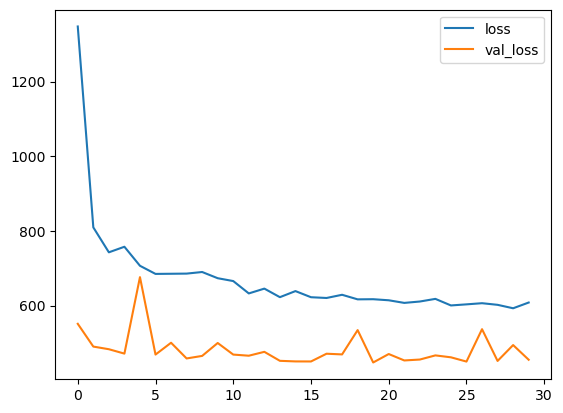

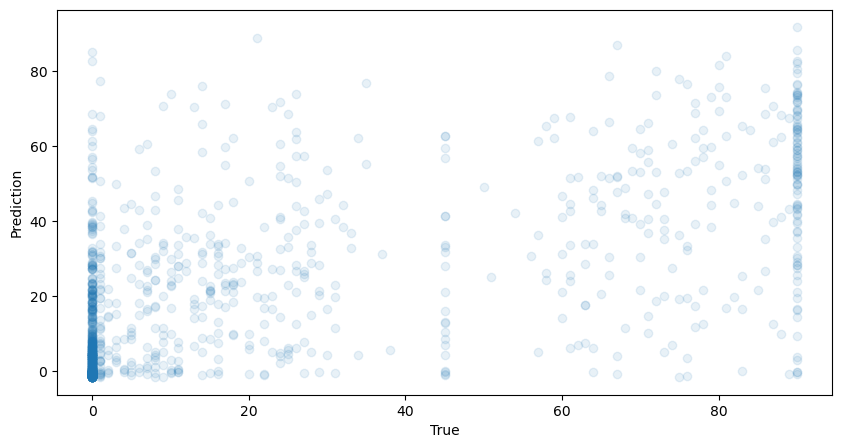

12.383570504527814


In [11]:
pos = 'FWD'

train_df = train_dict[pos] #full_dict[pos].sample(frac=0.75, random_state=4) 
val_df = val_dict[pos] #full_dict[pos].drop(train_df.index)

input_shape = np.shape(train_df.columns[:-1])

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=128, activation='leaky_relu',
                          input_shape=input_shape),
    # tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    # tf.keras.layers.Dense(units=128, activation='leaky_relu',
    #                       input_shape=input_shape),
    tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=128, activation='leaky_relu'),
    #tf.keras.layers.Dropout(0.1, noise_shape=None, seed=None),
    tf.keras.layers.Dense(units=1, activation='leaky_relu') #sigmoid')
])

model.compile(optimizer='adam', loss='mse') #'binary_crossentropy') #'mse')

model.summary()

# val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
# train_round = np.array([1 if train_out > 60 else 0 for train_out in list(train_df['out'])])

val_round = np.array([val_out for val_out in list(val_df['out'])])
train_round = np.array([train_out for train_out in list(train_df['out'])])

losses = model.fit(train_df[train_df.columns[:-1]], train_round, validation_data=(val_df[train_df.columns[:-1]], val_round), batch_size=128, epochs=30)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

# plt.figure(figsize=(10,5))
# plt.scatter(val_df['out'], pred, alpha=0.1)
# plt.xlabel('True')
# plt.ylabel('Prediction')
# plt.show()

pred_round = [round(pred_[0]) for pred_ in pred]

plt.figure(figsize=(10,5))
plt.scatter(val_round, pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

print (sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred))

<Axes: >

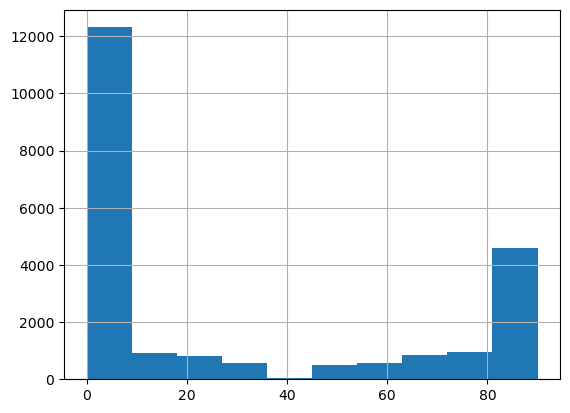

In [499]:
train_df.out.hist()

<Axes: >

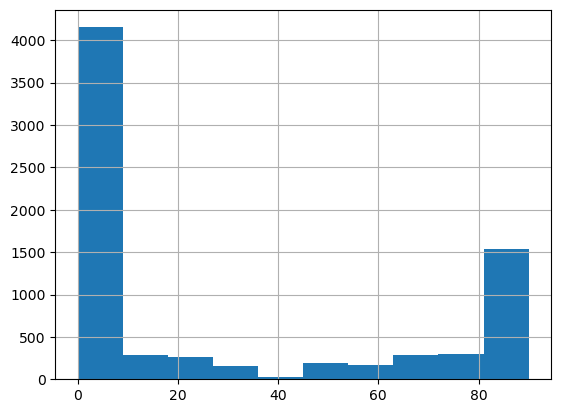

In [500]:
val_df.out.hist()

In [ ]:
pred_round = [round(pred_[0]) for pred_ in pred]
sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred))])/len(pred)

In [241]:
pred[0]

array([0.06240175], dtype=float32)

In [390]:
sum(val_round)

0

Epoch 1/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - loss: 734.8900 - val_loss: 674.4083
Epoch 2/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - loss: 690.7148 - val_loss: 674.9283
Epoch 3/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step - loss: 699.7871 - val_loss: 695.5148
Epoch 4/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - loss: 686.0697 - val_loss: 673.2390
Epoch 5/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 697.3524 - val_loss: 680.9540
Epoch 6/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 339us/step - loss: 690.8986 - val_loss: 684.3608
Epoch 7/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step - loss: 695.3264 - val_loss: 671.0057
Epoch 8/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 344us/step - loss: 674.8686 - val_loss: 670.9692
Epoch 9/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step - loss: 692.5473 - val_loss: 675.6692
Epoch 10/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - loss: 694.7142 - val_loss: 669.2950
Epoch 11/20
2380/2380 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - 

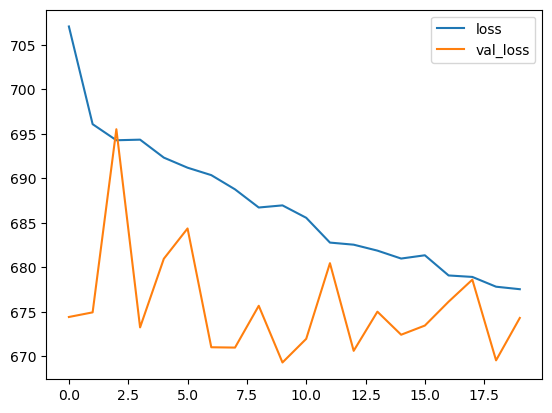

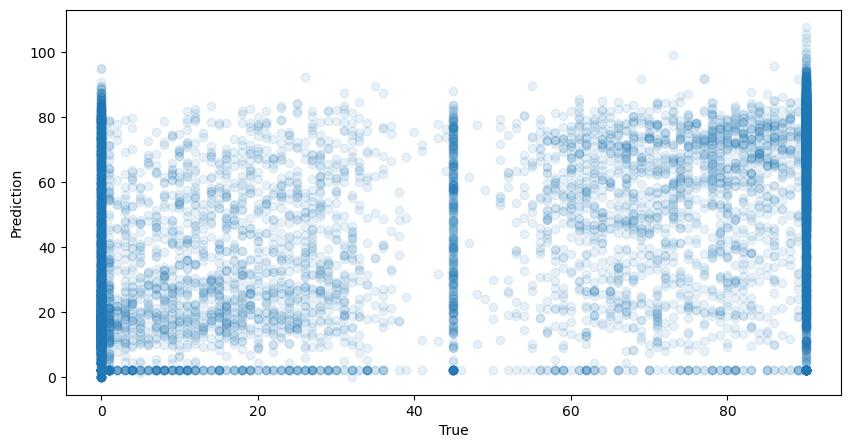

In [233]:
losses = model.fit(train_df[train_df.columns[:-1]], train_df['out'], validation_data=(val_df[train_df.columns[:-1]], val_df['out']), batch_size=24, epochs=20)

loss_df = pd.DataFrame(losses.history)

loss_df.loc[:,['loss','val_loss']].plot()

pred = model.predict(val_df[train_df.columns[:-1]])

plt.figure(figsize=(10,5))
plt.scatter(val_df['out'], pred, alpha=0.1)
plt.xlabel('True')
plt.ylabel('Prediction')
plt.show()

In [234]:
pred_round = np.array([1 if pred_[0] > 60 else 0 for pred_ in pred])
val_round = np.array([1 if val_out > 60 else 0 for val_out in list(val_df['out'])])
sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred_round))])/len(pred_round)

# pred_round = np.array([round(pred_[0]/90) for pred_ in pred])
# val_round = np.array([round(val_out/90) for val_out in list(val_df['out'])])
# sum([abs(pred_round[i] - val_round[i]) for i in range(len(pred_round))])/len(pred_round)

0.15167594830303668

In [196]:
val_round

array([0, 0, 0, ..., 1, 1, 1])

In [183]:
round(pred[1][0])

1

0.14274779946421737

In [118]:
val_df['out']

6         0.0
14        0.0
31       45.0
39        0.0
44        0.0
         ... 
20876    90.0
20889    90.0
20892    90.0
20893    90.0
20894    90.0
Name: out, Length: 5226, dtype: float64

In [123]:
pred - np.array(val_df['out'])

array([[  6.81342411,   6.81342411, -38.18657589, ..., -83.18657589,
        -83.18657589, -83.18657589],
       [ 45.70088959,  45.70088959,   0.70088959, ..., -44.29911041,
        -44.29911041, -44.29911041],
       [ 47.19889832,  47.19889832,   2.19889832, ..., -42.80110168,
        -42.80110168, -42.80110168],
       ...,
       [ 95.59453583,  95.59453583,  50.59453583, ...,   5.59453583,
          5.59453583,   5.59453583],
       [ 95.69671631,  95.69671631,  50.69671631, ...,   5.69671631,
          5.69671631,   5.69671631],
       [ 95.58895874,  95.58895874,  50.58895874, ...,   5.58895874,
          5.58895874,   5.58895874]])

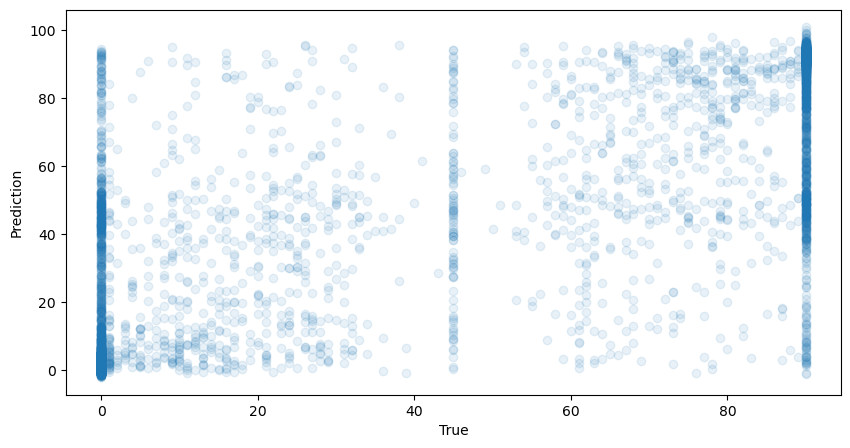

In [112]:
np.shape(val_df.iloc[0:3][:-1])

(2, 101)

In [111]:
input_shape

(100,)

In [29]:
player_time_set_background[0]

[1,
 0,
 0,
 0,
 0,
 4,
 424,
 10,
 10,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 4.2,
 0.1,
 4.0,
 0.8,
 0.02,
 0.0,
 0.02,
 0.19,
 1,
 0,
 0,
 0,
 0,
 5,
 424,
 13,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1.0,
 0.3,
 0.0,
 0.1,
 0.0,
 0.0,
 0.0,
 0.0]

In [38]:
table_list

[('player',),
 ('transaction',),
 ('transfer_suggestion',),
 ('fifa_rating',),
 ('team',),
 ('sessionteam',),
 ('sessionbudget',),
 ('player_mapping',),
 ('player_attributes',),
 ('absence',),
 ('fixture',),
 ('result',),
 ('player_prediction',),
 ('player_score',)]

In [32]:
df_absence = pd.read_sql_query("SELECT * FROM absence", con)
df_absence

,id,player_id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp
0,1,522,2425,injury,Ankle injury,2025-02-14,2025-04-28,25,35.0,/amad-diallo/profil/spieler/536835,2025-06-09T12:15:38.774168
1,2,689,2425,injury,Ill,2025-01-01,2025-01-17,20,22.0,/fraser-forster/profil/spieler/52570,2025-06-09T12:15:38.778684
2,3,581,2425,injury,Fitness,2025-03-03,2025-05-25,28,39.0,/jamaal-lascelles/profil/spieler/183318,2025-06-09T12:15:38.782880
3,4,485,2425,injury,unknown injury,2025-03-15,2025-03-17,29,30.0,/bernardo-silva/profil/spieler/241641,2025-06-09T12:15:38.787870
4,5,242,2425,injury,unknown injury,2025-04-30,2025-05-23,35,38.0,/christopher-nkunku/profil/spieler/344381,2025-06-09T12:15:38.792099
...,...,...,...,...,...,...,...,...,...,...,...
1404,1405,238,2223,injury,Ankle Injury,2022-07-28,2022-10-17,1,12.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.015834
1405,1406,238,2223,Transfer,Transferred to PSV Eindhoven,2022-07-01,2023-01-19,1,21.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.016019
1406,1407,1050,2223,injury,Foot Injury,2023-04-14,2023-05-08,31,36.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016216
1407,1408,1050,2223,injury,Leg Injury,2022-10-22,2022-11-14,13,17.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016416


In [36]:
df_player.merge(df_absence, on='player_id')

,player_id,fpl_api_id,name,id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp
0,2,None,Gabriel Fernando de Jesus,76,2425,injury,Cruciate ligament tear,2025-01-13,2025-11-22,21,39.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:39.018662
1,2,None,Gabriel Fernando de Jesus,77,2425,injury,Groin injury,2024-08-20,2024-09-04,2,4.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:39.022805
2,2,None,Gabriel Fernando de Jesus,661,2324,injury,Knee injury,2024-02-02,2024-02-24,23,26.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.062110
3,2,None,Gabriel Fernando de Jesus,662,2324,injury,Knee injury,2024-01-05,2024-01-18,21,22.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.062533
4,2,None,Gabriel Fernando de Jesus,663,2324,injury,Hamstring injury,2023-10-24,2023-11-19,10,13.0,/gabriel-jesus/profil/spieler/363205,2025-06-09T12:15:40.064792
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1357,None,Mislav Orsic,1403,2223,Transfer,Transferred to Dinamo Zagreb,2022-07-01,2023-01-05,1,20.0,/mislav-orsic/profil/spieler/119150,2025-06-09T12:15:41.013514
1405,1358,None,Carlos Alcaraz,1020,2223,Transfer,Transferred to Racing Club,2022-07-01,2023-01-10,1,20.0,/carlos-alcaraz/profil/spieler/748319,2025-06-09T12:15:40.582534
1406,1361,None,Lucas Rodrigues Moura da Silva,1216,2223,injury,Calf Injury,2022-08-29,2022-10-10,5,11.0,/lucas-moura/profil/spieler/77100,2025-06-09T12:15:40.860034
1407,1370,None,Vladimir Coufal,899,2223,injury,Hamstring Injury,2023-05-03,2023-05-16,35,37.0,/vladimir-coufal/profil/spieler/157672,2025-06-09T12:15:40.285142


In [37]:
df_absence.merge(df_player, on='player_id')

,id,player_id,season,reason,details,date_from,date_until,gw_from,gw_until,url,timestamp,fpl_api_id,name
0,1,522,2425,injury,Ankle injury,2025-02-14,2025-04-28,25,35.0,/amad-diallo/profil/spieler/536835,2025-06-09T12:15:38.774168,None,Amad Diallo
1,2,689,2425,injury,Ill,2025-01-01,2025-01-17,20,22.0,/fraser-forster/profil/spieler/52570,2025-06-09T12:15:38.778684,None,Fraser Forster
2,3,581,2425,injury,Fitness,2025-03-03,2025-05-25,28,39.0,/jamaal-lascelles/profil/spieler/183318,2025-06-09T12:15:38.782880,None,Jamaal Lascelles
3,4,485,2425,injury,unknown injury,2025-03-15,2025-03-17,29,30.0,/bernardo-silva/profil/spieler/241641,2025-06-09T12:15:38.787870,None,Bernardo Veiga de Carvalho e Silva
4,5,242,2425,injury,unknown injury,2025-04-30,2025-05-23,35,38.0,/christopher-nkunku/profil/spieler/344381,2025-06-09T12:15:38.792099,None,Christopher Nkunku
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1405,238,2223,injury,Ankle Injury,2022-07-28,2022-10-17,1,12.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.015834,None,Noni Madueke
1405,1406,238,2223,Transfer,Transferred to PSV Eindhoven,2022-07-01,2023-01-19,1,21.0,/noni-madueke/profil/spieler/503987,2025-06-09T12:15:41.016019,None,Noni Madueke
1406,1407,1050,2223,injury,Foot Injury,2023-04-14,2023-05-08,31,36.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016216,None,Raphaël Varane
1407,1408,1050,2223,injury,Leg Injury,2022-10-22,2022-11-14,13,17.0,/raphael-varane/profil/spieler/164770,2025-06-09T12:15:41.016416,None,Raphaël Varane


In [22]:
i_row = 0
for row in cur.execute("SELECT * FROM absence"):
    if i_row < 10:
        print(row)
        i_row += 1
    else:
        break

(1, 522, '2425', 'injury', 'Ankle injury', '2025-02-14', '2025-04-28', 25, 35, '/amad-diallo/profil/spieler/536835', '2025-06-09T12:15:38.774168')
(2, 689, '2425', 'injury', 'Ill', '2025-01-01', '2025-01-17', 20, 22, '/fraser-forster/profil/spieler/52570', '2025-06-09T12:15:38.778684')
(3, 581, '2425', 'injury', 'Fitness', '2025-03-03', '2025-05-25', 28, 39, '/jamaal-lascelles/profil/spieler/183318', '2025-06-09T12:15:38.782880')
(4, 485, '2425', 'injury', 'unknown injury', '2025-03-15', '2025-03-17', 29, 30, '/bernardo-silva/profil/spieler/241641', '2025-06-09T12:15:38.787870')
(5, 242, '2425', 'injury', 'unknown injury', '2025-04-30', '2025-05-23', 35, 38, '/christopher-nkunku/profil/spieler/344381', '2025-06-09T12:15:38.792099')
(6, 242, '2425', 'injury', 'Knock', '2025-04-30', None, 35, None, '/christopher-nkunku/profil/spieler/344381', '2025-06-09T12:15:38.792316')
(7, 713, '2425', 'injury', 'Hamstring injury', '2024-10-27', '2025-02-13', 10, 25, '/wilson-odobert/profil/spieler/74

In [ ]:
# Be sure to close the connection
con.close()